Make paper figures comparing the BIC statistics for (i) M31, (ii) M33, and (iii) synthetic thick-HI fits

(a) histograms of delta BIC

(b) delta BIC vs. apparent dark NHI

(c) maps of delta BIC

In [1]:
'''
Figure of the BIC for the full cube models.
'''

%matplotlib inline

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import os
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import Projection
from scipy import ndimage as nd
from astropy.stats import histogram as astro_hist
from tqdm import tqdm
from corner import hist2d

osjoin = os.path.join

repo_path = os.path.expanduser("~/ownCloud/project_code/ThickHIFitting/")

figures_path_png = osjoin(repo_path, "figures/png")
figures_path_pdf = osjoin(repo_path, "figures/pdf")


def save_figure(fig, plot_name):
    fig.savefig(f"{figures_path_pdf}/{plot_name}.pdf")
    fig.savefig(f"{figures_path_png}/{plot_name}.png")


paths_script = os.path.join(repo_path, "paths.py")
exec(compile(open(paths_script, "rb").read(), paths_script, 'exec'))

plotstyle_script = os.path.join(repo_path, "plotting_styles.py")
exec(compile(open(plotstyle_script, "rb").read(), plotstyle_script, 'exec'))

model_script = os.path.join(repo_path, "gaussian_model.py")
exec(compile(open(model_script, "rb").read(), model_script, 'exec'))

thickHI_model_script = os.path.join(repo_path, "thickHI_model.py")
exec(compile(open(thickHI_model_script, "rb").read(),
             thickHI_model_script, 'exec'))


In [2]:
# Enable/disable saving figures
save_figures = False

Load in all data products.

In [3]:
# M31

m31_cubename_K = f"{fifteenA_HI_BCtaper_wEBHIS_HI_file_dict['Cube'].rstrip('.fits')}_K.fits"

m31_cube = SpectralCube.read(m31_cubename_K, use_dask=True)
print(f'Opening cube {m31_cubename_K}')

m31_vels = m31_cube.spectral_axis.to(u.m / u.s)
      
# del m31_cube

m31_mom0 = Projection.from_hdu(fits.open(fifteenA_HI_BCtaper_wEBHIS_HI_file_dict['Moment0'])).to(u.K * u.km / u.s)
      
m31_multigauss_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_multigaussian_gausspy_fits_neighbcheck2_nomw.fits")
# m31_multigauss_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_multigaussian_gausspy_fits_neighbcheck2.fits")
m31_multigauss_hdu = fits.open(m31_multigauss_name)

m31_ngauss = np.isfinite(m31_multigauss_hdu[0].data).sum(0) // 3

m31_thickHI_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_simplethick_HI_fits_5kms_centlimit.fits")
m31_thickHI_hdu = fits.open(m31_thickHI_name)

m31_thickHI80_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_simplethick_HI_fits_80kms_centlimit.fits")
m31_thickHI80_hdu = fits.open(m31_thickHI_name)

# Keep only where the fit parameters are valid
m31_multigauss_hdu[2].data[m31_ngauss == 0] = np.NaN

m31_multigauss_bic_proj = Projection.from_hdu(m31_multigauss_hdu[2])
      
# Split the different fit statistics
m31_thickHI_bic_proj = Projection.from_hdu(fits.PrimaryHDU(m31_thickHI_hdu[2].data[0], m31_thickHI_hdu[2].header))
m31_thickHI80_bic_proj = Projection.from_hdu(fits.PrimaryHDU(m31_thickHI80_hdu[2].data[0], m31_thickHI_hdu[2].header))
      
m31_thickHI_rchi_proj = Projection.from_hdu(fits.PrimaryHDU(m31_thickHI_hdu[2].data[2], m31_thickHI_hdu[2].header))
m31_thickHI80_rchi_proj = Projection.from_hdu(fits.PrimaryHDU(m31_thickHI80_hdu[2].data[2], m31_thickHI_hdu[2].header))
      
# Lastly, the recomputed statistics limited to where tau > 0.5
m31_modcompare_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_recomp_bic_tau_gt_0p5_5kms_centlimit.fits")
m31_modcompare_hdu = fits.open(m31_modcompare_name)
      
m31_modcompare80_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_recomp_bic_tau_gt_0p5_80kms_centlimit.fits")
m31_modcompare80_hdu = fits.open(m31_modcompare_name)
      
# Slice out to zoom into the valid data region.
spat_slice_zoom_m31 = tuple([slice(vals.min() - 10, vals.max() + 10) for vals in
                             np.where(np.isfinite(m31_multigauss_hdu[2].data))])
print(spat_slice_zoom_m31)
# Make custom slice so the array shapes are roughly the same in M33 and M31
spat_slice_zoom_m31 = (slice(105, 1709), slice(347, 1603))

Opening cube /mnt/bigdata/ekoch/M31/VLA/15A-175/HI/full_imaging_BCD_taper_0_42kms_wEBHIS/M31_15A_B_C_14A_HI_contsub_width_0_4kms.image.pbcor.EBHIS_feathered_K.fits
(slice(247, 1568, None), slice(338, 1611, None))


In [4]:
# M33

cube_name = fourteenB_HI_data_wGBT_path("M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked.fits")

downsamp_cube_name = f"{cube_name.rstrip('.fits')}_0p42kms_K.fits"
        
m33_cube = SpectralCube.read(downsamp_cube_name, use_dask=True)
print(f'Opening cube {downsamp_cube_name}')

m33_vels = m33_cube.spectral_axis.to(u.m / u.s)
      
# del m33_cube

m33_mom0_name = "M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked.moment0_Kkms.fits"
m33_mom0 = Projection.from_hdu(fits.open(fourteenB_HI_data_wGBT_path(m33_mom0_name))).to(u.K * u.km / u.s)

m33_multigauss_name = fourteenB_HI_data_wGBT_path("individ_multigaussian_gausspy_fits_neighbcheck2_nomw.fits")
# m33_multigauss_name = fourteenB_HI_data_wGBT_path("individ_multigaussian_gausspy_fits_neighbcheck2.fits")
m33_multigauss_hdu = fits.open(m33_multigauss_name)

m33_ngauss = np.isfinite(m33_multigauss_hdu[0].data).sum(0) // 3

m33_thickHI_name = fourteenB_HI_data_wGBT_path("individ_simplethick_HI_fits_5kms_centlimit.fits")
m33_thickHI_hdu = fits.open(m33_thickHI_name)

m33_thickHI80_name = fourteenB_HI_data_wGBT_path("individ_simplethick_HI_fits_80kms_centlimit.fits")
m33_thickHI80_hdu = fits.open(m33_thickHI_name)

# Keep only where the fit parameters are valid
m33_multigauss_hdu[2].data[m33_ngauss == 0] = np.NaN

m33_multigauss_bic_proj = Projection.from_hdu(m33_multigauss_hdu[2])

# Split the different fit statistics
m33_thickHI_bic_proj = Projection.from_hdu(fits.PrimaryHDU(m33_thickHI_hdu[2].data[0], m33_thickHI_hdu[2].header))
m33_thickHI80_bic_proj = Projection.from_hdu(fits.PrimaryHDU(m33_thickHI80_hdu[2].data[0], m33_thickHI_hdu[2].header))

m33_thickHI_rchi_proj = Projection.from_hdu(fits.PrimaryHDU(m33_thickHI_hdu[2].data[2], m33_thickHI_hdu[2].header))
m33_thickHI80_rchi_proj = Projection.from_hdu(fits.PrimaryHDU(m33_thickHI80_hdu[2].data[2], m33_thickHI_hdu[2].header))

# Lastly, the recomputed statistics limited to where tau > 0.5
m33_modcompare_name = fourteenB_HI_data_wGBT_path("individ_recomp_bic_tau_gt_0p5_5kms_centlimit.fits")
m33_modcompare_hdu = fits.open(m33_modcompare_name)
      
m33_modcompare80_name = fourteenB_HI_data_wGBT_path("individ_recomp_bic_tau_gt_0p5_80kms_centlimit.fits")
m33_modcompare80_hdu = fits.open(m33_modcompare_name)

# Slice out to zoom into the valid data region.
spat_slice_zoom_m33 = (slice(None), slice(None))


Opening cube /mnt/bigdata/ekoch/M33/VLA/14B-088/HI/full_imaging_wGBT/M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked_0p42kms_K.fits


In [5]:
# Synthetic
# Produced from simrecovery/montecarli_thickHI_multigauss_comparison.py
from astropy.table import Table

# output_name = 'm31_synthetic_thickHI_multigauss_comparison.csv'
output_name = 'm31_synthetic_thickHI_multigauss_comparison_with_lowtau.csv'
tab = Table.read(f"../simrecovery/{output_name}")

In [6]:
def darkNHI_fraction(vels, params, uncerts, spec, max_ts=8000, min_tp=0., min_ts=16):
    '''
    Compute the fraction of apparent dark NHI
    
    params: Ts, sigma, Tpeak, vcent
    '''
    
    if not np.isfinite(uncerts).all():
        uncerts = np.array([0, 0, 0, 0])
    
    # isoturbHI_simple wants km/s. Check the units in one place.
    # force converting to km/s everywhere
    
    mod_thickHI = isoturbHI_simple(vels.to(u.km / u.s).value, params[0],
                                   params[1],
                                   params[2],
                                   params[3])

    # Tp + sigma_Tp and Ts - sigma_Ts
    mod_thickHI_up = isoturbHI_simple(vels.to(u.km / u.s).value,
                                      max(params[0] - uncerts[0], min_ts),
                                      params[1],
                                      params[2] + uncerts[2],
                                      params[3])
    
    # Tp - sigma_Tp and Ts + sigma_Ts
    mod_thickHI_dn = isoturbHI_simple(vels.to(u.km / u.s).value,
                                      min(params[0] + uncerts[0], max_ts),
                                      params[1],
                                      max(params[2] - uncerts[2], min_tp),
                                      params[3])
    
    # Compute the model residuals. These are used in the Braun+09 style "correction"
    # maps for total NHI (their Eq. 5):
    residsum_thickHI = (spec.value - mod_thickHI).sum()
    residsum_thickHI_up = (spec.value - mod_thickHI_up).sum()
    residsum_thickHI_dn = (spec.value - mod_thickHI_dn).sum()

    # Make equivalent "optically-thin" models to calculate inferred missing intensity
    # fractions, etc.
    par = np.array([params[2], params[3],
                    params[1]])
    
    par_up = np.array([params[2] + uncerts[2], params[3],
                       params[1]])
    
    par_dn = np.array([max(params[2] - uncerts[2], min_tp), params[3],
                       params[1]])
    
    mod_thickHI_thinlimit = multigaussian_nolmfit(vels.to(u.km / u.s).value, par)
    missing_intint = (mod_thickHI_thinlimit - mod_thickHI).sum() 
    
    mod_thickHI_thinlimit_up = multigaussian_nolmfit(vels.to(u.km / u.s).value, par_up)
    missing_intint_up = (mod_thickHI_thinlimit_up - mod_thickHI_up).sum() 
    
    mod_thickHI_thinlimit_dn = multigaussian_nolmfit(vels.to(u.km / u.s).value, par_dn)
    missing_intint_dn = (mod_thickHI_thinlimit_dn - mod_thickHI_dn).sum() 
    
    # Missing vs. total opt.thin actual
    missing_intint_frac = missing_intint / mod_thickHI_thinlimit.sum()
    missing_intint_frac_up = missing_intint_up / mod_thickHI_thinlimit_up.sum()
    missing_intint_frac_dn = missing_intint_dn / mod_thickHI_thinlimit_dn.sum()
    
    # Detected vs. dark
    missing_intint_corr = missing_intint / mod_thickHI.sum()
    missing_intint_corr_up = missing_intint_up / mod_thickHI_up.sum()
    missing_intint_corr_dn = missing_intint_dn / mod_thickHI_dn.sum()
    
    diff_vel = np.abs(vels[1] - vels[0]).to(u.km / u.s).value
    
    return [missing_intint * diff_vel * u.K * u.km / u.s,
            missing_intint_dn * diff_vel * u.K * u.km / u.s,
            missing_intint_up * diff_vel * u.K * u.km / u.s,
            missing_intint_frac, missing_intint_frac_dn, missing_intint_frac_up,
            missing_intint_corr, missing_intint_corr_dn, missing_intint_corr_up,
            residsum_thickHI * diff_vel * u.K * u.km / u.s,
            residsum_thickHI_dn * diff_vel * u.K * u.km / u.s,
            residsum_thickHI_up * diff_vel * u.K * u.km / u.s]

Opaque fit parameters: [  51.48747802   13.48472458  476.4438184  -169.04063136]
Equiv. thin parameters: [ 476.4438184  -169.04063136   13.48472458]
Equiv. opt thin int: 16016.241904005788
Missing opaque int 13141.878128228787
Residual int -12.15323524331578
Actual moment 0 value: 3117.3202287597655 K km / s
Opaque fit direct intint value: 3265.003822216167
Actual moment 0 - fit intint value: -147.68359345640147
Sum of spec int: 3252.8505761718748 K km / s
[<Quantity 12899.56583475 K km / s>, <Quantity 9449.92810619 K km / s>, <Quantity 16397.3127948 K km / s>, 0.8009979085558289, 0.7539360890526946, 0.8334248666214246, 4.025072815782664, 3.0639848247155212, 5.003297009087785, <Quantity -11.92915172 K km / s>, <Quantity 108.67848091 K km / s>, <Quantity -84.42755286 K km / s>]


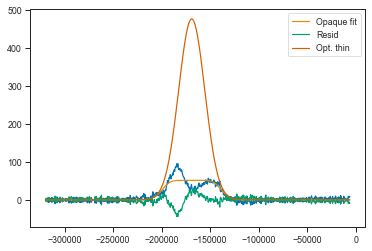

In [11]:
# M31 test case:

# y, x = 900, 1000
y, x = 500, 900

test_pars = m31_thickHI_hdu[0].data[:, y, x]

print(f"Opaque fit parameters: {test_pars}")

# Equiv. opt-thin:
par = np.array([test_pars[2], test_pars[3],
                test_pars[1]])

print(f"Equiv. thin parameters: {par}")

test_mod = isoturbHI_simple(m31_vels.to(u.km / u.s).value,
                            test_pars[0],
                            test_pars[1],
                            test_pars[2],
                            test_pars[3])
test_spec = m31_cube[:, y, x]

mod_thickHI_thinlimit = multigaussian_nolmfit(m31_vels.to(u.km / u.s).value, par)
missing_intint = (mod_thickHI_thinlimit - test_mod).sum() 


plt.plot(m31_vels.value, test_spec.value)
plt.plot(m31_vels.value, test_mod, label='Opaque fit')
plt.plot(m31_vels.value, test_mod - test_spec.value, label='Resid')
plt.plot(m31_vels.value, mod_thickHI_thinlimit, label='Opt. thin')
plt.legend()

print(f"Equiv. opt thin int: {0.41 * mod_thickHI_thinlimit.sum()}")
print(f"Missing opaque int {0.42 * (mod_thickHI_thinlimit - test_mod).sum()}")
print(f"Residual int {0.42 * (test_spec.value - test_mod).sum()}")
print(f"Actual moment 0 value: {m31_mom0[y, x]}")
print(f"Opaque fit direct intint value: {test_mod.sum() * 0.42}")
print(f"Actual moment 0 - fit intint value: {m31_mom0[y, x].value - test_mod.sum() * 0.42}")
print(f"Sum of spec int: {test_spec.sum() * 0.42 * u.km / u.s}")

out = darkNHI_fraction(m31_vels,
                       m31_thickHI_hdu[0].data[:, y, x],
                       m31_thickHI_hdu[1].data[:, y, x],
                       m31_cube[:, y, x])

print(out)

Opaque fit parameters: [ 203.60989717   10.37078388   45.25489103 -127.29174805]
Equiv. thin parameters: [  45.25489103 -127.29174805   10.37078388]
Equiv. opt thin int: 1170.0782950326673
Missing opaque int 88.75531073148959
Residual int -24.33279009742453
Residual int -24.332822075411993
Actual moment 0 value: 618.5672693451747 K km / s
Opaque fit direct intint value: 1109.8614793019744
Actual moment 0 - fit intint value: -491.2942099567997
Sum of spec int: 1085.5286572265625 K km / s
[<Quantity 87.11260504 K km / s>, <Quantity 31.11184486 K km / s>, <Quantity 760.80470859 K km / s>, 0.07404811234874462, 0.030519144474217632, 0.5705560185082402, 0.0799697190926119, 0.03147988358951768, 1.3285924197291108, <Quantity -23.88243268 K km / s>, <Quantity 77.12868555 K km / s>, <Quantity 492.79779247 K km / s>]


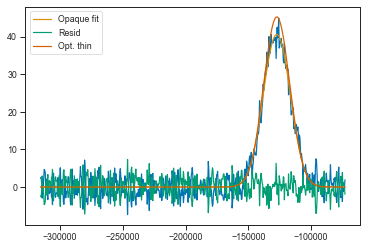

In [14]:
# M33 test case:

# y, x = 950, 420
y, x = 600, 850

test_pars = m33_thickHI_hdu[0].data[:, y, x]

print(f"Opaque fit parameters: {test_pars}")

# Equiv. opt-thin:
par = np.array([test_pars[2], test_pars[3],
                test_pars[1]])

print(f"Equiv. thin parameters: {par}")

test_mod = isoturbHI_simple(m33_vels.to(u.km / u.s).value,
                            test_pars[0],
                            test_pars[1],
                            test_pars[2],
                            test_pars[3])
test_spec = m33_cube[:, y, x]

mod_thickHI_thinlimit = multigaussian_nolmfit(m33_vels.to(u.km / u.s).value, par)
missing_intint = (mod_thickHI_thinlimit - test_mod).sum() 


plt.plot(m33_vels.value, test_spec.value)
plt.plot(m33_vels.value, test_mod, label='Opaque fit')
plt.plot(m33_vels.value, test_mod - test_spec.value, label='Resid')
plt.plot(m33_vels.value, mod_thickHI_thinlimit, label='Opt. thin')
plt.legend()

print(f"Equiv. opt thin int: {0.41 * mod_thickHI_thinlimit.sum()}")
print(f"Missing opaque int {0.42 * (mod_thickHI_thinlimit - test_mod).sum()}")
print(f"Residual int {0.42 * (test_spec.value - test_mod).sum()}")
print(f"Residual int {0.42 * (test_spec.value.sum() - test_mod.sum())}")
print(f"Actual moment 0 value: {m33_mom0[y, x]}")
print(f"Opaque fit direct intint value: {test_mod.sum() * 0.42}")
print(f"Actual moment 0 - fit intint value: {m33_mom0[y, x].value - test_mod.sum() * 0.42}")
print(f"Sum of spec int: {test_spec.sum() * 0.42 * u.km / u.s}")


out = darkNHI_fraction(m33_vels,
                       m33_thickHI_hdu[0].data[:, y, x],
                       m33_thickHI_hdu[1].data[:, y, x],
                       m33_cube[:, y, x])

print(out)

In [26]:
# Compute all the dark NHI fractions
# Further, compute upper and low limits on everything.

m31_darknhi = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m31_darknhi_up = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m31_darknhi_low = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s

m31_darknhi80 = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m31_darknhi80_up = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m31_darknhi80_low = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s

m31_darknhi_frac = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi_frac_up = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi_frac_low = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN

m31_darknhi80_frac = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi80_frac_up = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi80_frac_low = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN

m31_darknhi_corr = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi_corr_up = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi_corr_low = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN

m31_darknhi80_corr = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi80_corr_up = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi80_corr_low = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN

m31_residsum = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m31_residsum_up = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m31_residsum_low = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s

m31_residsum80 = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m31_residsum80_up = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m31_residsum80_low = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s

# yy, xx = np.indices(m31_darknhi.shape)
yy, xx = np.where(np.isfinite(m31_thickHI_hdu[1].data[0]))
for (y, x) in tqdm(zip(yy.ravel(), xx.ravel()), total=yy.size):
    m31_darknhi[y, x], m31_darknhi_low[y, x], m31_darknhi_up[y, x], \
    m31_darknhi_frac[y, x], m31_darknhi_frac_low[y, x], m31_darknhi_frac_up[y, x], \
    m31_darknhi_corr[y, x], m31_darknhi_corr_low[y, x], m31_darknhi_corr_up[y, x], \
    m31_residsum[y, x], m31_residsum_low[y, x], m31_residsum_up[y, x] = \
        darkNHI_fraction(m31_vels,
                         m31_thickHI_hdu[0].data[:, y, x],
                         m31_thickHI_hdu[1].data[:, y, x],
                         m31_cube[:, y, x])
    
    m31_darknhi80[y, x], m31_darknhi80_low[y, x], m31_darknhi80_up[y, x], \
    m31_darknhi80_frac[y, x], m31_darknhi80_frac_low[y, x], m31_darknhi80_frac_up[y, x], \
    m31_darknhi80_corr[y, x], m31_darknhi80_corr_low[y, x], m31_darknhi80_corr_up[y, x], \
    m31_residsum80[y, x], m31_residsum80_low[y, x], m31_residsum80_up[y, x] = \
        darkNHI_fraction(m31_vels,
                         m31_thickHI80_hdu[0].data[:, y, x],
                         m31_thickHI80_hdu[1].data[:, y, x],
                         m31_cube[:, y, x])
    

m33_darknhi = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m33_darknhi_up = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m33_darknhi_low = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s

m33_darknhi80 = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m33_darknhi80_up = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m33_darknhi80_low = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s

m33_darknhi_frac = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi_frac_up = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi_frac_low = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN

m33_darknhi80_frac = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi80_frac_up = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi80_frac_low = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN

m33_darknhi_corr = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi_corr_up = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi_corr_low = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN

m33_darknhi80_corr = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi80_corr_up = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi80_corr_low = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN


m33_residsum = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m33_residsum_up = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m33_residsum_low = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s

m33_residsum80 = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m33_residsum80_up = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s
m33_residsum80_low = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN * u.K * u.km / u.s

# yy, xx = np.indices(m33_darknhi.shape)
yy, xx = np.where(np.isfinite(m33_thickHI_hdu[1].data[0]))
for (y, x) in tqdm(zip(yy.ravel(), xx.ravel()), total=yy.size):
    m33_darknhi[y, x], m33_darknhi_low[y, x], m33_darknhi_up[y, x], \
    m33_darknhi_frac[y, x], m33_darknhi_frac_low[y, x], m33_darknhi_frac_up[y, x], \
    m33_darknhi_corr[y, x], m33_darknhi_corr_low[y, x], m33_darknhi_corr_up[y, x], \
    m33_residsum[y, x], m33_residsum_low[y, x], m33_residsum_up[y, x] = \
        darkNHI_fraction(m33_vels,
                         m33_thickHI_hdu[0].data[:, y, x],
                         m33_thickHI_hdu[1].data[:, y, x],
                         m33_cube[:, y, x])
    
    m33_darknhi80[y, x], m33_darknhi80_low[y, x], m33_darknhi80_up[y, x], \
    m33_darknhi80_frac[y, x], m33_darknhi80_frac_low[y, x], m33_darknhi80_frac_up[y, x], \
    m33_darknhi80_corr[y, x], m33_darknhi80_corr_low[y, x], m33_darknhi80_corr_up[y, x], \
    m33_residsum80[y, x], m33_residsum80_low[y, x], m33_residsum80_up[y, x] = \
        darkNHI_fraction(m33_vels,
                         m33_thickHI80_hdu[0].data[:, y, x],
                         m33_thickHI80_hdu[1].data[:, y, x],
                         m33_cube[:, y, x])
    

100%|██████████| 953711/953711 [4:32:54<00:00, 58.24it/s]


Save these dark HI intensity maps to FITS files. Should probably be its own script:

In [27]:

m31_darkhi_hdu = fits.HDUList([fits.PrimaryHDU(m31_darknhi.value, m31_mom0.header),
                               fits.ImageHDU(m31_darknhi_low.value, m31_mom0.header),
                               fits.ImageHDU(m31_darknhi_up.value, m31_mom0.header),
                               fits.ImageHDU(m31_residsum.value, m31_mom0.header),
                               fits.ImageHDU(m31_residsum_low.value, m31_mom0.header),
                               fits.ImageHDU(m31_residsum_up.value, m31_mom0.header)])

m33_darkhi_hdu = fits.HDUList([fits.PrimaryHDU(m33_darknhi.value, m33_mom0.header),
                               fits.ImageHDU(m33_darknhi_low.value, m33_mom0.header),
                               fits.ImageHDU(m33_darknhi_up.value, m33_mom0.header),
                               fits.ImageHDU(m33_residsum.value, m33_mom0.header),
                               fits.ImageHDU(m33_residsum_low.value, m33_mom0.header),
                               fits.ImageHDU(m33_residsum_up.value, m33_mom0.header)])


m31_darkhi_hdu.writeto(fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_simplethick_HI_fits_5kms_centlimit_darkHI.fits", no_check=True),
                       overwrite=True)

m33_darkhi_hdu.writeto(fourteenB_HI_data_wGBT_path("individ_simplethick_HI_fits_5kms_centlimit_darkHI.fits", no_check=True),
                       overwrite=True)

del m31_darkhi_hdu, m33_darkhi_hdu

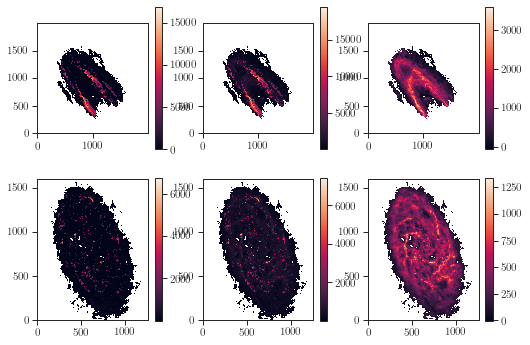

In [76]:
twocolumn_figure()

plt.subplot(231)
plt.imshow(m31_darknhi.value, origin='lower')
plt.colorbar()

plt.subplot(232)
plt.imshow(m31_darknhi.value + m31_mom0.value, origin='lower')
plt.colorbar()

plt.subplot(233)
plt.imshow(m31_mom0.value, origin='lower')
plt.colorbar()


plt.subplot(234)
plt.imshow(m33_darknhi.value, origin='lower')
plt.colorbar()

plt.subplot(235)
plt.imshow(m33_darknhi.value + m33_mom0.value, origin='lower')
plt.colorbar()

plt.subplot(236)
plt.imshow(m33_mom0.value, origin='lower')
plt.colorbar()

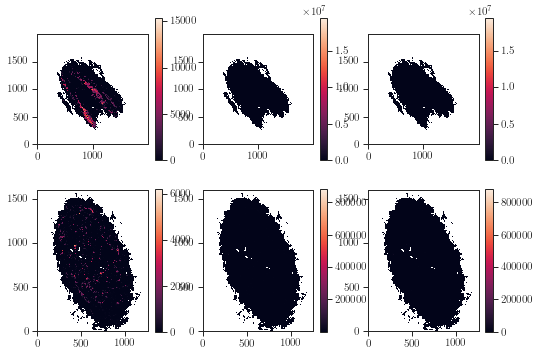

In [78]:

plt.subplot(231)
plt.imshow(m31_darknhi_low.value, origin='lower')
plt.colorbar()

plt.subplot(234)
plt.imshow(m33_darknhi_low.value, origin='lower')#, vmax=5e7, vmin=0)
plt.colorbar()

plt.subplot(232)
# plt.imshow(m31_darknhi_up, origin='lower', vmin=0)#, vmax=5e7, vmin=0)
plt.imshow(m31_darknhi_up.value, origin='lower')#, vmax=5e7, vmin=0)

plt.colorbar()

plt.subplot(235)
# plt.imshow(m33_darknhi_up, origin='lower', vmin=0)#, vmax=5e7, vmin=0)
plt.imshow(m33_darknhi_up.value, origin='lower')#, vmax=5e7, vmin=0)

plt.colorbar()

plt.subplot(233)
plt.imshow(m31_darknhi_up.value - m31_darknhi_low.value, origin='lower')
plt.colorbar()


plt.subplot(236)
plt.imshow(m33_darknhi_up.value - m33_darknhi_low.value, origin='lower')
plt.colorbar()


15709.575684439502 K km / s
-1.8885964374847396e-13 K km / s
14.889878221680192 K km / s
6156.578386365221 K km / s
0.0 K km / s
7.709331713125721 K km / s


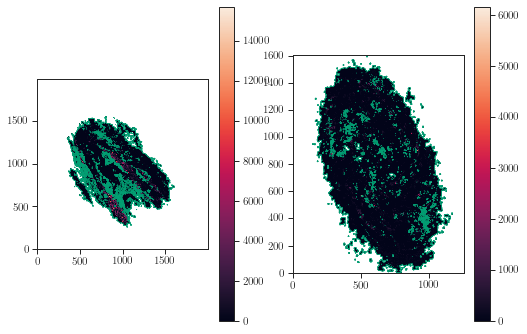

In [84]:
twocolumn_figure()

plt.subplot(121)
plt.imshow(m31_darknhi.value - m31_darknhi_low.value, origin='lower')
plt.colorbar()
plt.contour(m31_darknhi.value > m31_darknhi_low.value, colors='g', linewidths=0.3)

plt.subplot(122)
plt.imshow(m33_darknhi.value - m33_darknhi_low.value, origin='lower')
plt.colorbar()
plt.contour(m33_darknhi.value > m33_darknhi_low.value, colors='g', linewidths=0.3)

print(np.nanmax(m31_darknhi - m31_darknhi_low))
print(np.nanmin(m31_darknhi - m31_darknhi_low))
print(np.nanmax(m31_darknhi - m31_darknhi_up))

print(np.nanmax(m33_darknhi - m33_darknhi_low))
print(np.nanmin(m33_darknhi - m33_darknhi_low))
print(np.nanmax(m33_darknhi - m33_darknhi_up))


(b) delta BIC vs. apparent dark NHI

In [85]:
diff_bic_m31 = m31_multigauss_bic_proj - m31_thickHI_bic_proj
diff_bic_m31_zoom = diff_bic_m31[spat_slice_zoom_m31]

valids_mask_m31 = np.logical_and(np.isfinite(diff_bic_m31), m31_ngauss > 0)

diff_bic_m33 = m33_multigauss_bic_proj - m33_thickHI_bic_proj
diff_bic_m33_zoom = diff_bic_m33[spat_slice_zoom_m33]

valids_mask_m33 = np.logical_and(np.isfinite(diff_bic_m33), m33_ngauss > 0)

Text(0, 0.5, 'Apparent Dark NHI Fraction')

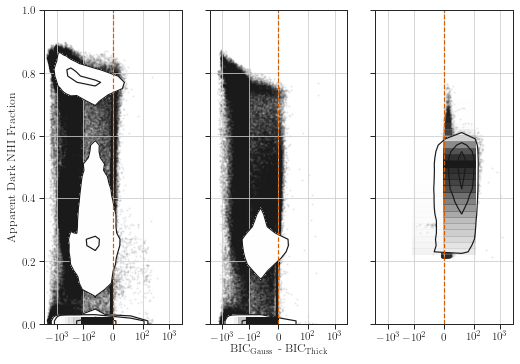

In [86]:
twocolumn_figure()


fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

# ranges = [(-2500, 500), (0.0, 1.0)]
ranges = [(-3000, 3000), (0.0, 1.0)]

hist2d(diff_bic_m31[valids_mask_m31 & np.isfinite(m31_darknhi_frac)],
       m31_darknhi_frac[valids_mask_m31 & np.isfinite(m31_darknhi_frac)],
       ax=axs[0],
       bins=50,
       range=ranges)

hist2d(diff_bic_m33[valids_mask_m33 & np.isfinite(m33_darknhi_frac)],
       m33_darknhi_frac[valids_mask_m33 & np.isfinite(m33_darknhi_frac)],
       ax=axs[1],
       bins=50,
       range=ranges)

tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_taulim']))
hist2d((tab['mgauss_BIC'] - tab['thick_BIC'])[tab_finites],
       tab['darkint_taulim'][tab_finites] / tab['optthinint_taulim'][tab_finites],
       ax=axs[2],
       bins=50,
       range=ranges)

axs[0].axvline(0., color='r', linestyle='--')
axs[1].axvline(0., color='r', linestyle='--')
axs[2].axvline(0., color='r', linestyle='--')

axs[0].set_xscale('symlog', linthreshx=100.)

[ax.grid() for ax in axs]

axs[1].set_xlabel(r"BIC$_{\rm Gauss}$ - BIC$_{\rm Thick}$")
axs[0].set_ylabel("Apparent Dark NHI Fraction")

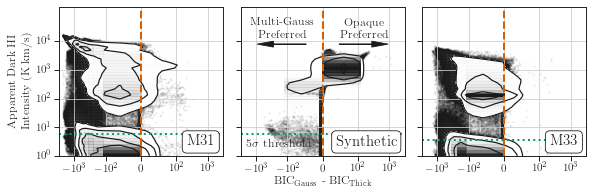

In [87]:
# twocolumn_figure()
twocolumn_twopanel_figure()


diff_bic_m31 = m31_multigauss_bic_proj - m31_thickHI_bic_proj
diff_bic_m31_zoom = diff_bic_m31[spat_slice_zoom_m31]

valids_mask_m31 = np.logical_and(np.isfinite(diff_bic_m31), m31_ngauss > 0)

diff_bic_m33 = m33_multigauss_bic_proj - m33_thickHI_bic_proj
diff_bic_m33_zoom = diff_bic_m33[spat_slice_zoom_m33]

valids_mask_m33 = np.logical_and(np.isfinite(diff_bic_m33), m33_ngauss > 0)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

# ranges = [(-2500, 500), (0.0, 8000.0)]
ranges = [(-3000, 3000), (0.0, 5.2)]
# ranges = None

hist2d(diff_bic_m31[valids_mask_m31 & np.isfinite(m31_darknhi_frac)],
       np.log10(m31_darknhi[valids_mask_m31 & np.isfinite(m31_darknhi_frac)].value),
       ax=axs[0],
       bins=50,
       range=ranges)

hist2d(diff_bic_m33[valids_mask_m33 & np.isfinite(m33_darknhi_frac)],
       np.log10(m33_darknhi[valids_mask_m33 & np.isfinite(m33_darknhi_frac)].value),
       ax=axs[2],
       bins=50,
       range=ranges)

tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_total']))
hist2d((tab['mgauss_BIC'] - tab['thick_BIC'])[tab_finites],
       np.log10(tab['darkint_total'][tab_finites] / 1000),
       ax=axs[1],
       bins=50,
       range=ranges)

axs[0].axvline(0., color='r', linestyle='--', linewidth=2)
axs[1].axvline(0., color='r', linestyle='--', linewidth=2)
axs[2].axvline(0., color='r', linestyle='--', linewidth=2)

# M31 5-sigma integrated intensity per channel
axs[0].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
# M33 5-sigma integrated intensity per channel
axs[2].axhline(np.log10(5 * 0.42 * 2.4 / np.sqrt(2)), color='g', linestyle=':', linewidth=2)
# M31 noise used for synthetic tests
axs[1].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)

[ax.grid() for ax in axs]

axs[0].set_xscale('symlog', linthreshx=100.)

axs[1].set_xlabel(r"BIC$_{\rm Gauss}$ - BIC$_{\rm Thick}$")
axs[0].set_ylabel("Apparent Dark HI\nIntensity (K km/s)")

axs[0].set_yticks([0, 1, 2, 3, 4])
axs[0].set_yticklabels([r'10$^0$', r'10$^1$', r'10$^2$', r'10$^3$', r'10$^4$'])

# Make various text labels in the plots
# Labels
bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp = 0.95
yp = 0.05

axs[0].text(xp, yp, "M31", transform=axs[0].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[2].text(xp, yp, "M33", transform=axs[2].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[1].text(xp, yp, "Synthetic", transform=axs[1].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)

# BIC model preference
axs[1].text(0.25, 0.85, "Multi-Gauss\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.4, 0.75, -0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

axs[1].text(0.75, 0.85, "Opaque\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.6, 0.75, 0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

# Label horizontal line
axs[1].text(-2e3, np.log10(5 * 0.42 * 2.8) - 0.2,
            r"$5\sigma$ threshold",
            horizontalalignment='left', verticalalignment='top')
            
#             bbox=bbox_props)

plt.tight_layout()

plot_name = 'm31_m33_synth_diffBIC_darkintint'

if save_figures:
    save_figure(fig, plot_name)

Now make a 6-panel figure with tau cuts in the 2nd row

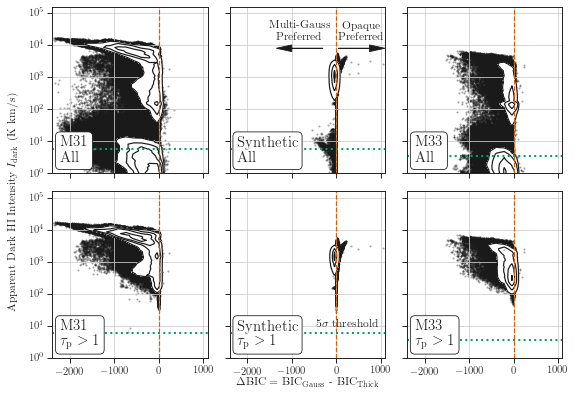

In [88]:
twocolumn_figure(font_scale=1.2)
# twocolumn_twopanel_figure()


diff_bic_m31 = m31_multigauss_bic_proj - m31_thickHI_bic_proj
diff_bic_m31_zoom = diff_bic_m31[spat_slice_zoom_m31]

valids_mask_m31 = np.logical_and(np.isfinite(diff_bic_m31), m31_ngauss > 0)

diff_bic_m33 = m33_multigauss_bic_proj - m33_thickHI_bic_proj
diff_bic_m33_zoom = diff_bic_m33[spat_slice_zoom_m33]

valids_mask_m33 = np.logical_and(np.isfinite(diff_bic_m33), m33_ngauss > 0)

taupeak_lim = 1.0
m31taupeak_mask = (m31_thickHI_hdu[0].data[2] / m31_thickHI_hdu[0].data[0]) > taupeak_lim
m33taupeak_mask = (m33_thickHI_hdu[0].data[2] / m33_thickHI_hdu[0].data[0]) > taupeak_lim

valids_mask_m31_taulim = np.logical_and(valids_mask_m31, m31taupeak_mask)
valids_mask_m33_taulim = np.logical_and(valids_mask_m33, m33taupeak_mask)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

axs = axs.ravel()

# ranges = [(-2500, 500), (0.0, 8000.0)]
# ranges = [(-3000, 3000), (0.0, 5.2)]
ranges = [(-2400, 1100), (0.0, 5.2)]
# ranges = None

levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)
bins = [20, 100]
plot_density = False
alpha_dat = 0.4

hist2d(diff_bic_m31[valids_mask_m31 & np.isfinite(m31_darknhi_frac)],
       np.log10(m31_darknhi[valids_mask_m31 & np.isfinite(m31_darknhi_frac)].value),
       ax=axs[0],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

hist2d(diff_bic_m31[valids_mask_m31_taulim & np.isfinite(m31_darknhi_frac)],
       np.log10(m31_darknhi[valids_mask_m31_taulim & np.isfinite(m31_darknhi_frac)].value),
       ax=axs[3],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

hist2d(diff_bic_m33[valids_mask_m33 & np.isfinite(m33_darknhi_frac)],
       np.log10(m33_darknhi[valids_mask_m33 & np.isfinite(m33_darknhi_frac)].value),
       ax=axs[2],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

hist2d(diff_bic_m33[valids_mask_m33_taulim & np.isfinite(m33_darknhi_frac)],
       np.log10(m33_darknhi[valids_mask_m33_taulim & np.isfinite(m33_darknhi_frac)].value),
       ax=axs[5],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})


tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_total']))
tab_finites_taulim = np.logical_and(tab_finites, tab['Tpeak'] / tab['Ts'] > taupeak_lim)

hist2d((tab['mgauss_BIC'] - tab['thick_BIC'])[tab_finites],
       np.log10(tab['darkint_total'][tab_finites] / 1000),
       ax=axs[1],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_taulim']))
tab_finites_taulim = np.logical_and(tab_finites, tab['Tpeak'] / tab['Ts'] > taupeak_lim)

hist2d((tab['mgauss_BIC'] - tab['thick_BIC'])[tab_finites_taulim],
       np.log10(tab['darkint_total'][tab_finites_taulim] / 1000),
       ax=axs[4],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

for ax in axs:
    ax.axvline(0., color='r', linestyle='--')

# M31 5-sigma integrated intensity per channel
axs[0].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
axs[3].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
# M33 5-sigma integrated intensity per channel
axs[2].axhline(np.log10(5 * 0.42 * 2.4 / np.sqrt(2)), color='g', linestyle=':',
               linewidth=2)
axs[5].axhline(np.log10(5 * 0.42 * 2.4 / np.sqrt(2)), color='g', linestyle=':',
               linewidth=2)
# M31 noise used for synthetic tests
axs[1].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
axs[4].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)

[ax.grid() for ax in axs]

# axs[0].set_xscale('symlog', linthreshx=100.)

axs[4].set_xlabel(r"$\Delta {\rm BIC} = $ BIC$_{\rm Gauss}$ - BIC$_{\rm Thick}$")

# axs[0].set_ylabel("Apparent Dark HI\nIntensity (K km/s)")
fig.text(0.06, 0.5, r"Apparent Dark HI Intensity $I_{\rm dark}$ (K km/s)",
         ha='center', va='center', rotation='vertical')

axs[0].set_yticks([0, 1, 2, 3, 4, 5])
axs[0].set_yticklabels([r'10$^0$', r'10$^1$', r'10$^2$', r'10$^3$', r'10$^4$', r'10$^5$'])

# Make various text labels in the plots
# Labels
bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp = 0.05
yp = 0.05

axs[0].text(xp, yp, "M31\nAll", transform=axs[0].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[2].text(xp, yp, "M33\nAll", transform=axs[2].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[1].text(xp, yp, "Synthetic\nAll", transform=axs[1].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)

axs[3].text(xp, yp, "M31\n$\\tau_{\\mathrm{p}} > 1$", transform=axs[3].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[5].text(xp, yp, "M33\n$\\tau_{\\mathrm{p}} > 1$", transform=axs[5].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[4].text(xp, yp, "Synthetic\n$\\tau_{\\mathrm{p}} > 1$", transform=axs[4].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)

# BIC model preference
# axs[1].text(0.25, 0.85, "Multi-Gauss\nPreferred",
axs[1].text(0.45, 0.85, "Multi-Gauss\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

# axs[1].arrow(0.4, 0.75, -0.2, 0.0, head_width=0.04,
axs[1].arrow(0.6, 0.75, -0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

# axs[1].text(0.75, 0.85, "Opaque\nPreferred",
axs[1].text(0.85, 0.85, "Opaque\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.7, 0.75, 0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

# Label horizontal line
# axs[1].text(-2e2, np.log10(5 * 0.42 * 2.8) - 0.2,
#             r"$5\sigma$ threshold",
#             horizontalalignment='center', verticalalignment='top')
            
# axs[1].text(-2e2, np.log10(5 * 0.42 * 2.8) - 0.2,
#             r"$5\sigma$ threshold",
#             color='w',
#             horizontalalignment='center', verticalalignment='top',
#             fontsize=13)
    
axs[4].text(9.7e2, np.log10(5 * 0.42 * 2.8) + 0.1,
            r"$5\sigma$" + " threshold",
            horizontalalignment='right', verticalalignment='bottom')
    
plt.tight_layout()
fig.subplots_adjust(left=0.125, bottom=0.125)

plot_name = 'm31_m33_synth_diffBIC_darkintint_withtaulim'

if save_figures:
    save_figure(fig, plot_name)

From this plot, compute the fraction of "missing" integrated intensity where $$\Delta {\rm BIC} > 0$$.

In [102]:
hi_mass_conversion = 0.0196 * (u.M_sun / u.pc ** 2) / (u.K * u.km / u.s)

d_m31 = 744 * u.kpc
pix_area_m31 = ((3 * u.arcsec).to(u.rad).value * d_m31).to(u.pc)**2


m31_thickHI_pref = diff_bic_m31[valids_mask_m31 & np.isfinite(m31_darknhi_frac)] > 0.
m31_missing_intint_lim = (m31_darknhi[valids_mask_m31 & np.isfinite(m31_darknhi_frac)])[m31_thickHI_pref].sum()

m31_missing_intint_lim_up = np.nansum((m31_darknhi_up[valids_mask_m31 & np.isfinite(m31_darknhi_frac)])[m31_thickHI_pref])

m31_missing_intint_lim_low = np.nansum((m31_darknhi_low[valids_mask_m31 & np.isfinite(m31_darknhi_frac)])[m31_thickHI_pref])

m31_missing_hi_mass_lim = m31_missing_intint_lim * hi_mass_conversion * pix_area_m31
m31_missing_hi_mass_lim_up = m31_missing_intint_lim_up * hi_mass_conversion * pix_area_m31
m31_missing_hi_mass_lim_low = m31_missing_intint_lim_low * hi_mass_conversion * pix_area_m31

# Total mass estimate
# Moment 0
m31_total_intint = np.nansum(m31_mom0)
m31_total_optthin_mass = m31_total_intint * hi_mass_conversion * pix_area_m31


d_m33 = 840 * u.kpc
pix_area_m33 = ((3 * u.arcsec).to(u.rad).value * d_m33).to(u.pc)**2

m33_thickHI_pref = diff_bic_m33[valids_mask_m33 & np.isfinite(m33_darknhi_frac)] > 0.
m33_missing_intint_lim = (m33_darknhi[valids_mask_m33 & np.isfinite(m33_darknhi_frac)])[m33_thickHI_pref].sum()

m33_missing_intint_lim_up = np.nansum((m33_darknhi_up[valids_mask_m33 & np.isfinite(m33_darknhi_frac)])[m33_thickHI_pref])

m33_missing_intint_lim_low = np.nansum((m33_darknhi_low[valids_mask_m33 & np.isfinite(m33_darknhi_frac)])[m33_thickHI_pref])

m33_missing_hi_mass_lim = m33_missing_intint_lim * hi_mass_conversion * pix_area_m33
m33_missing_hi_mass_lim_up = m33_missing_intint_lim_up * hi_mass_conversion * pix_area_m33
m33_missing_hi_mass_lim_low = m33_missing_intint_lim_low * hi_mass_conversion * pix_area_m33


m33_total_intint = np.nansum(m33_mom0)
m33_total_optthin_mass = m33_total_intint * hi_mass_conversion * pix_area_m33


In [103]:
print(f"{m31_missing_hi_mass_lim} +{m31_missing_hi_mass_lim_up - m31_missing_hi_mass_lim} -{m31_missing_hi_mass_lim - m31_missing_hi_mass_lim_low}")

22935637.208837412 solMass +15626276.184920259 solMass -10245926.294134438 solMass


In [104]:
print(f"{m33_missing_hi_mass_lim} +{m33_missing_hi_mass_lim_up - m33_missing_hi_mass_lim} -{m33_missing_hi_mass_lim - m33_missing_hi_mass_lim_low}")


8826205.912756223 solMass +4093754.91679837 solMass -2895108.9007437164 solMass


In [105]:
m33_missing_hi_mass_lim

<Quantity 8826205.91275622 solMass>

In [98]:
m31_total_optthin_mass

<Projection 1.7187686e+09 solMass>

In [106]:
m33_total_optthin_mass

<Projection 1.02029634e+09 solMass>

In [107]:
print(f"% of dark HI in M31: {100 * m31_missing_hi_mass_lim / m31_total_optthin_mass}")
print(f"+1 sigma % of dark HI in M31: {100 * (m31_missing_hi_mass_lim_up - m31_missing_hi_mass_lim) / m31_total_optthin_mass}")
print(f"-1 sigma % of dark HI in M31: {100 * (m31_missing_hi_mass_lim - m31_missing_hi_mass_lim_low) / m31_total_optthin_mass}")


% of dark HI in M31: 1.33442263489971
+1 sigma % of dark HI in M31: 0.909155322369561
-1 sigma % of dark HI in M31: 0.5961201704541671


In [108]:
print(f"% of dark HI in M33: {100 * m33_missing_hi_mass_lim / m33_total_optthin_mass}")
print(f"+1 sigma % of dark HI in M33: {100 * (m33_missing_hi_mass_lim_up - m33_missing_hi_mass_lim) / m33_total_optthin_mass}")
print(f"-1 sigma % of dark HI in M33: {100 * (m33_missing_hi_mass_lim - m33_missing_hi_mass_lim_low) / m33_total_optthin_mass}")


% of dark HI in M33: 0.8650629753396657
+1 sigma % of dark HI in M33: 0.4012319499048599
-1 sigma % of dark HI in M33: 0.2837517665421908


In [109]:
nspec = (m31_thickHI_pref).sum()
m31_nspec_all = m31_thickHI_pref.size
print(f"% of spectra in M31 comparison: {100 * nspec / m31_nspec_all}")

% of spectra in M31 comparison: 1.6427959804592644


In [110]:
nspec = (m33_thickHI_pref).sum()
m33_nspec_all = m33_thickHI_pref.size
print(f"% of spectra in M33 comparison: {100 * nspec / m33_nspec_all}")

% of spectra in M33 comparison: 0.7700461716258619


And what would we imply the correction factor is with no model selection?

In [111]:
m31_missing_intint_all = np.nansum((m31_darknhi[valids_mask_m31 & np.isfinite(m31_darknhi_frac)]))

m31_missing_intint_all_up = np.nansum((m31_darknhi_up[valids_mask_m31 & np.isfinite(m31_darknhi_frac)]))

m31_missing_intint_all_low = np.nansum((m31_darknhi_low[valids_mask_m31 & np.isfinite(m31_darknhi_frac)]))

m31_missing_hi_mass_all = m31_missing_intint_all * hi_mass_conversion * pix_area_m31
m31_missing_hi_mass_all_up = m31_missing_intint_all_up * hi_mass_conversion * pix_area_m31
m31_missing_hi_mass_all_low = m31_missing_intint_all_low * hi_mass_conversion * pix_area_m31


print(f"% of dark HI in M31: {100 * m31_missing_hi_mass_all / m31_total_optthin_mass}")
print(f"+1 sigma % of dark HI in M31: {100 * (m31_missing_hi_mass_all_up - m31_missing_hi_mass_all) / m31_total_optthin_mass}")
print(f"-1 sigma % of dark HI in M31: {100 * (m31_missing_hi_mass_all - m31_missing_hi_mass_all_low) / m31_total_optthin_mass}")

% of dark HI in M31: 117.97092668084036
+1 sigma % of dark HI in M31: 119.21347209349304
-1 sigma % of dark HI in M31: 39.8584235740449


In [112]:
m31_missing_hi_mass_all

<Quantity 2.02764724e+09 solMass>

In [113]:
print(f"{m31_missing_hi_mass_all} +{m31_missing_hi_mass_all_up - m31_missing_hi_mass_all} -{m31_missing_hi_mass_all - m31_missing_hi_mass_all_low}")


2027647242.1688693 solMass +2049003722.5333145 solMass -685074067.9164009 solMass


In [114]:
m33_missing_intint_all = np.nansum((m33_darknhi[valids_mask_m33 & np.isfinite(m33_darknhi_frac)]))

m33_missing_intint_all_up = np.nansum((m33_darknhi_up[valids_mask_m33 & np.isfinite(m33_darknhi_frac)]))

m33_missing_intint_all_low = np.nansum((m33_darknhi_low[valids_mask_m33 & np.isfinite(m33_darknhi_frac)]))

m33_missing_hi_mass_all = m33_missing_intint_all * hi_mass_conversion * pix_area_m33
m33_missing_hi_mass_all_up = m33_missing_intint_all_up * hi_mass_conversion * pix_area_m33
m33_missing_hi_mass_all_low = m33_missing_intint_all_low * hi_mass_conversion * pix_area_m33


print(f"% of dark HI in M33: {100 * m33_missing_hi_mass_all / m33_total_optthin_mass}")
print(f"+1 sigma % of dark HI in M33: {100 * (m33_missing_hi_mass_all_up - m33_missing_hi_mass_all) / m33_total_optthin_mass}")
print(f"-1 sigma % of dark HI in M33: {100 * (m33_missing_hi_mass_all - m33_missing_hi_mass_all_low) / m33_total_optthin_mass}")

% of dark HI in M33: 36.68981052626233
+1 sigma % of dark HI in M33: 83.03449890960097
-1 sigma % of dark HI in M33: 11.688328323203818


In [115]:
m33_missing_hi_mass_all

<Quantity 3.74344796e+08 solMass>

In [116]:
print(f"{m33_missing_hi_mass_all} +{m33_missing_hi_mass_all_up - m33_missing_hi_mass_all} -{m33_missing_hi_mass_all - m33_missing_hi_mass_all_low}")


374344795.5076912 solMass +847197956.8318784 solMass -119255586.5843068 solMass


M33 looks fine. M31 has a bunch of clearly too large corrections for a population of spectra. So let's add in the red. chisq < 25 cut-off used by Braun 09,12.

% spectra with chisq < 25: 1.0
% spectra with chisq < 25: 1.0
% spectra with chisq < 1: 0.21134009578956506
% spectra with chisq < 1: 0.08157841609682112


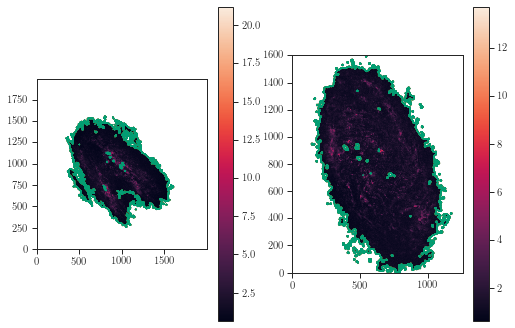

In [117]:
m31_chisq_mask = m31_thickHI_rchi_proj < 25
m33_chisq_mask = m33_thickHI_rchi_proj < 25

plt.subplot(121)
plt.imshow(m31_thickHI_rchi_proj.value, origin='lower')
plt.colorbar()
plt.contour(m31_chisq_mask, colors='r')
plt.contour(m31_thickHI_rchi_proj < 10., colors='g')
plt.subplot(122)
plt.imshow(m33_thickHI_rchi_proj.value, origin='lower')
plt.colorbar()
plt.contour(m33_chisq_mask, colors='r')
plt.contour(m33_thickHI_rchi_proj < 10., colors='g')

print(f"% spectra with chisq < 25: {m31_chisq_mask.sum() / np.isfinite(m31_thickHI_rchi_proj).sum()}")
print(f"% spectra with chisq < 25: {m33_chisq_mask.sum() / np.isfinite(m33_thickHI_rchi_proj).sum()}")

print(f"% spectra with chisq < 1: {(m31_thickHI_rchi_proj < 1.).sum() / np.isfinite(m31_thickHI_rchi_proj).sum()}")
print(f"% spectra with chisq < 1: {(m33_thickHI_rchi_proj < 1.).sum() / np.isfinite(m33_thickHI_rchi_proj).sum()}")


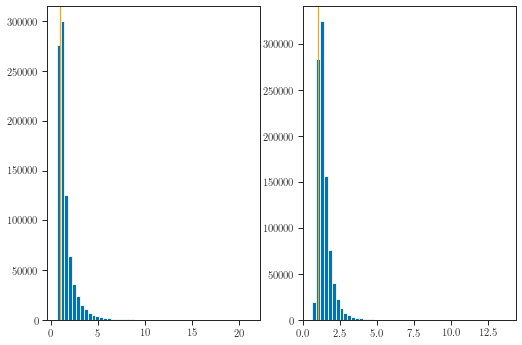

In [118]:
plt.subplot(121)
_ = plt.hist(m31_thickHI_rchi_proj.value[np.isfinite(m31_thickHI_rchi_proj.value)], bins=50)
plt.axvline(1., color='orange')
plt.subplot(122)
_ = plt.hist(m33_thickHI_rchi_proj.value[np.isfinite(m33_thickHI_rchi_proj.value)], bins=50)
plt.axvline(1., color='orange')


Conclusion: The reduced chisq cut-off used in Braun 2009/2012 does not provide any measure of poor fits when used with our new data.

Add plot of inferred mass correction as function of reduced chi sq.

Several of the taus are very large and likely not physical. What is the mass correction if we remove all LOS with peak tau >3?

In [119]:
# This would be better as a plot... choosing 8 as the demonstration value for the table just for now

taupeak_lim_high = 5.0
m31taupeak_mask = (m31_thickHI_hdu[0].data[2] / m31_thickHI_hdu[0].data[0]) < taupeak_lim_high
m33taupeak_mask = (m33_thickHI_hdu[0].data[2] / m33_thickHI_hdu[0].data[0]) < taupeak_lim_high

# See towards the end a cut-off based on uncertainty in tau


In [120]:
m31_missing_intint_taulim = (m31_darknhi[m31taupeak_mask & np.isfinite(m31_darknhi_frac)]).sum()

m31_missing_intint_taulim_up = np.nansum((m31_darknhi_up[m31taupeak_mask & np.isfinite(m31_darknhi_frac)]))

m31_missing_intint_taulim_low = np.nansum((m31_darknhi_low[m31taupeak_mask & np.isfinite(m31_darknhi_frac)]))

m31_missing_hi_mass_taulim = m31_missing_intint_taulim * hi_mass_conversion * pix_area_m31
m31_missing_hi_mass_taulim_up = m31_missing_intint_taulim_up * hi_mass_conversion * pix_area_m31
m31_missing_hi_mass_taulim_low = m31_missing_intint_taulim_low * hi_mass_conversion * pix_area_m31


print(f"Dark HI Mass: {m31_missing_hi_mass_taulim} + {m31_missing_hi_mass_taulim_up - m31_missing_hi_mass_taulim} - {m31_missing_hi_mass_taulim - m31_missing_hi_mass_taulim_low}")
print(f"Dark HI Mass: {100 * m31_missing_hi_mass_taulim / m31_total_optthin_mass} + {100 * (m31_missing_hi_mass_taulim_up - m31_missing_hi_mass_taulim) / m31_total_optthin_mass} - {100 * (m31_missing_hi_mass_taulim - m31_missing_hi_mass_taulim_low) / m31_total_optthin_mass}")
print(f"% of dark HI in M31 with peak tau < {taupeak_lim_high}: {100 * m31_missing_hi_mass_taulim / m31_total_optthin_mass}")
print(f"% of spectra {100 * (m31taupeak_mask & np.isfinite(m31_darknhi_frac)).sum() / np.isfinite(m31_darknhi).sum()}")

Dark HI Mass: 199688758.02427304 solMass + 785688316.9172841 solMass - 86281816.64534108 solMass
Dark HI Mass: 11.618129298798237 + 45.712280174483325 - 5.0199786499694925
% of dark HI in M31 with peak tau < 5.0: 11.618129298798237
% of spectra 85.78509005774652


In [121]:
m33_missing_intint_taulim = (m33_darknhi[m33taupeak_mask & np.isfinite(m33_darknhi_frac)]).sum()

m33_missing_intint_taulim_up = np.nansum((m33_darknhi_up[m33taupeak_mask & np.isfinite(m33_darknhi_frac)]))

m33_missing_intint_taulim_low = np.nansum((m33_darknhi_low[m33taupeak_mask & np.isfinite(m33_darknhi_frac)]))

m33_missing_hi_mass_taulim = m33_missing_intint_taulim * hi_mass_conversion * pix_area_m33
m33_missing_hi_mass_taulim_up = m33_missing_intint_taulim_up * hi_mass_conversion * pix_area_m33
m33_missing_hi_mass_taulim_low = m33_missing_intint_taulim_low * hi_mass_conversion * pix_area_m33


print(f"Dark HI Mass: {m33_missing_hi_mass_taulim} + {m33_missing_hi_mass_taulim_up - m33_missing_hi_mass_taulim} - {m33_missing_hi_mass_taulim - m33_missing_hi_mass_taulim_low}")
print(f"Dark HI Mass: {100 * m33_missing_hi_mass_taulim / m33_total_optthin_mass} + {100 * (m33_missing_hi_mass_taulim_up - m33_missing_hi_mass_taulim) / m33_total_optthin_mass} - {100 * (m33_missing_hi_mass_taulim - m33_missing_hi_mass_taulim_low) / m33_total_optthin_mass}")
print(f"% of dark HI in M33 with peak tau < {taupeak_lim_high}: {100 * m33_missing_hi_mass_taulim / m33_total_optthin_mass}")
print(f"% of spectra {100 * (m33taupeak_mask & np.isfinite(m33_darknhi_frac)).sum() / np.isfinite(m33_darknhi).sum()}")

Dark HI Mass: 193485070.8225624 solMass + 797663093.9345725 solMass - 74757928.05232534 solMass
Dark HI Mass: 18.96361502371791 + 78.17955032755452 - 7.327079869925462
% of dark HI in M33 with peak tau < 5.0: 18.96361502371791
% of spectra 97.33151810995905


Make BIC maps. Two panel figure

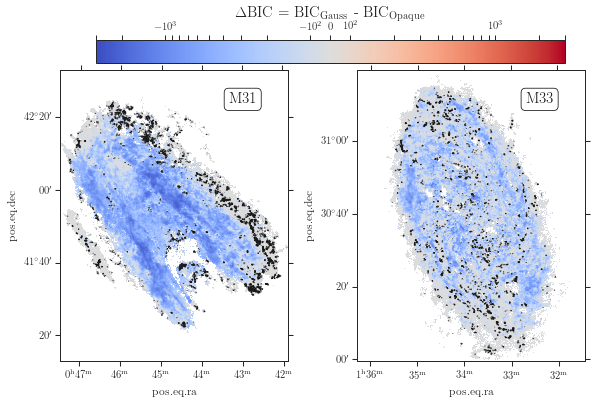

In [122]:
twocolumn_figure(font_scale=1.2)

import matplotlib.colors as colors

vmin = -3000
vmax = 3000

norm = colors.SymLogNorm(linthresh=100., linscale=0.2,
                         vmin=vmin, vmax=vmax)

fig = plt.figure()

diff_bic_zoom_m31 = diff_bic_m31[spat_slice_zoom_m31]

ax = fig.add_subplot(121, projection=diff_bic_zoom_m31.wcs)

im = ax.imshow(diff_bic_zoom_m31.value, # vmin=vmin, vmax=vmax,
               norm=norm,
               cmap=plt.cm.coolwarm)
#                cmap=plt.cm.Oranges_r)

ax.contour(diff_bic_zoom_m31.value, levels=[0], colors='k')

diff_bic_zoom_m33 = diff_bic_m33[spat_slice_zoom_m33]

ax2 = fig.add_subplot(122, projection=diff_bic_zoom_m33.wcs)

# Scale to the 95% in image
# vmin, vmax = np.nanpercentile(diff_bic_zoom_m33, [2.5, 97.5])

im2 = ax2.imshow(diff_bic_zoom_m33.value, # vmin=vmin, vmax=vmax,
                 norm=norm,
                 cmap=plt.cm.coolwarm)
#                  cmap=plt.cm.Oranges_r)

ax2.contour(diff_bic_zoom_m33.value, levels=[0], colors='k')

# cbar = plt.colorbar(im2)
cbar = fig.colorbar(im, ax=[ax, ax2], location='top')

cbar.set_label(r"$\Delta$BIC = BIC$_{\rm Gauss}$ - BIC$_{\rm Opaque}$", fontsize=15)

xp = 0.8
yp = 0.9

ax.text(xp, yp, "M31", transform=ax.transAxes,
        horizontalalignment='center',
        verticalalignment='center',
        bbox=bbox_props, fontsize=15)

ax2.text(xp, yp, "M33", transform=ax2.transAxes,
         horizontalalignment='center',
         verticalalignment='center',
         bbox=bbox_props, fontsize=15)

# plt.tight_layout()

fig.subplots_adjust(right=0.95, left=0.05, bottom=0.05, top=0.75)

if save_figures:
    save_figure(fig, 'm31_m33_delta_bic_map')


Make a figure of the tau limited BIC comparisons only.

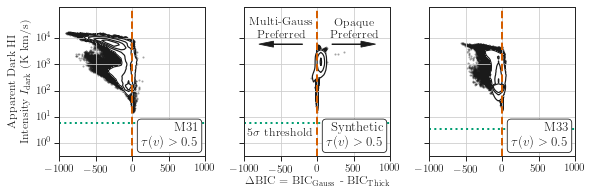

In [124]:
# twocolumn_figure()
twocolumn_twopanel_figure()


diff_bic_m31_taulim = m31_modcompare_hdu[1].data - m31_modcompare_hdu[0].data
darknhi_m31_taulim = m31_modcompare_hdu[6].data

# valids_mask_m31 = np.logical_and(np.isfinite(diff_bic_m31_taulim), m31_ngauss > 0)
valids_mask_m31 = np.isfinite(diff_bic_m31_taulim)

diff_bic_m33_taulim = m33_modcompare_hdu[1].data - m33_modcompare_hdu[0].data
darknhi_m33_taulim = m33_modcompare_hdu[6].data

# valids_mask_m33 = np.logical_and(np.isfinite(diff_bic_m33), m33_ngauss > 0)
valids_mask_m33 = np.isfinite(diff_bic_m33)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

# ranges = [(-2500, 500), (0.0, 8000.0)]
# ranges = [(-3000, 3000), (0.0, 5.2)]
ranges = [(-1000, 1000), (-0.5, 5.2)]
# ranges = None

plot_density = False
bins = [20, 100]
alpha_dat = 0.4

hist2d(diff_bic_m31_taulim[valids_mask_m31 & np.isfinite(darknhi_m31_taulim)],
       np.log10(m31_darknhi[valids_mask_m31 & np.isfinite(darknhi_m31_taulim)].value),
       ax=axs[0],
       bins=bins,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

hist2d(diff_bic_m33_taulim[valids_mask_m33 & np.isfinite(darknhi_m33_taulim)],
       np.log10(m33_darknhi[valids_mask_m33 & np.isfinite(darknhi_m33_taulim)].value),
       ax=axs[2],
       bins=bins,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_taulim']))
hist2d((tab['mgauss_BIC_taulim'] - tab['thick_BIC_taulim'])[tab_finites],
       np.log10(tab['darkint_taulim'][tab_finites] / 1000),
       ax=axs[1],
       bins=bins,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

axs[0].axvline(0., color='r', linestyle='--', linewidth=2)
axs[1].axvline(0., color='r', linestyle='--', linewidth=2)
axs[2].axvline(0., color='r', linestyle='--', linewidth=2)

# M31 5-sigma integrated intensity per channel
axs[0].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
# M33 5-sigma integrated intensity per channel
axs[2].axhline(np.log10(5 * 0.42 * 2.4 / np.sqrt(2)), color='g', linestyle=':', linewidth=2)
# M31 noise used for synthetic tests
axs[1].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)

[ax.grid() for ax in axs]

# axs[0].set_xscale('symlog', linthreshx=100.)

axs[1].set_xlabel(r"$\Delta {\rm BIC} = $ BIC$_{\rm Gauss}$ - BIC$_{\rm Thick}$")
axs[0].set_ylabel("Apparent Dark HI\n" + r"Intensity $I_{\rm dark}$ (K km/s)")

axs[0].set_yticks([0, 1, 2, 3, 4])
axs[0].set_yticklabels([r'10$^0$', r'10$^1$', r'10$^2$', r'10$^3$', r'10$^4$'])

# Make various text labels in the plots
# Labels
bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp = 0.95
yp = 0.05

axs[0].text(xp, yp, "M31\n" + r"$\tau(v) > 0.5$",
            transform=axs[0].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=13)
axs[2].text(xp, yp, "M33\n" + r"$\tau(v) > 0.5$",
            transform=axs[2].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=13)
axs[1].text(xp, yp, "Synthetic\n" + r"$\tau(v) > 0.5$",
            transform=axs[1].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=13)

# BIC model preference
axs[1].text(0.25, 0.85, "Multi-Gauss\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.4, 0.75, -0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

axs[1].text(0.75, 0.85, "Opaque\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.6, 0.75, 0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

# Label horizontal line
axs[1].text(-9.65e2, np.log10(5 * 0.42 * 2.8) - 0.2,
            r"$5\sigma$ threshold",
            horizontalalignment='left', verticalalignment='top')
            
#             bbox=bbox_props)

plt.tight_layout()

plot_name = 'm31_m33_synth_diffBIC_darkintint_taulim_only'

if save_figures:
    save_figure(fig, plot_name)


Calculate fraction of spectra preferred in different categories: (i) Delta BIC < -10; (ii) -10 > Delta BIC < 10; and (iii) Delta BIC > 10. Include the synthetic comparison.

In [125]:
m31_frac_i = (diff_bic_m31 < -10).sum() / np.isfinite(diff_bic_m31).sum()
m31_frac_ii = np.logical_and(diff_bic_m31 > -10, diff_bic_m31 < 10).sum() / np.isfinite(diff_bic_m31).sum()
m31_frac_iii = (diff_bic_m31 > 10).sum() / np.isfinite(diff_bic_m31).sum()

print(f"M31 fracs (i): {m31_frac_i}; (ii): {m31_frac_ii}; (iii): {m31_frac_iii}")
print(f"Sanity sum check: {m31_frac_i + m31_frac_ii + m31_frac_iii}")

M31 fracs (i): 0.8198106050254604; (ii): 0.17515326366034353; (iii): 0.005036131314196035
Sanity sum check: 1.0


In [126]:
m33_frac_i = (diff_bic_m33 < -10).sum() / np.isfinite(diff_bic_m33).sum()
m33_frac_ii = np.logical_and(diff_bic_m33 > -10, diff_bic_m33 < 10).sum() / np.isfinite(diff_bic_m33).sum()
m33_frac_iii = (diff_bic_m33 > 10).sum() / np.isfinite(diff_bic_m33).sum()

print(f"M33 fracs (i): {m33_frac_i}; (ii): {m33_frac_ii}; (iii): {m33_frac_iii}")
print(f"Sanity sum check: {m33_frac_i + m33_frac_ii + m33_frac_iii}")

M33 fracs (i): 0.8024452831196046; (ii): 0.1961042760197856; (iii): 0.0014504408606097413
Sanity sum check: 1.0


In [127]:
# tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_total']))

synth_bic_diff = tab['mgauss_BIC'] - tab['thick_BIC']
tab_finites = np.isfinite(synth_bic_diff)

synth_frac_i = (synth_bic_diff < -10).sum() / tab_finites.sum()
synth_frac_ii = np.logical_and(synth_bic_diff > -10, synth_bic_diff < 10).sum() / tab_finites.sum()
synth_frac_iii = (synth_bic_diff > 10).sum() / tab_finites.sum()

print(f"Synth fracs (i): {synth_frac_i}; (ii): {synth_frac_ii}; (iii): {synth_frac_iii}")
print(f"Sanity sum check: {synth_frac_i + synth_frac_ii + synth_frac_iii}")

Synth fracs (i): 0.010925382388383593; (ii): 0.49892746246118613; (iii): 0.4901471551504303
Sanity sum check: 1.0


Same comparison, only for lines-of-sight with apparent opaque HI (tau_peak > 1)

In [128]:
taupeak_lim = 1.0
thickmask = (m31_thickHI_hdu[0].data[2] / m31_thickHI_hdu[0].data[0]) > taupeak_lim

m31_frac_i = (diff_bic_m31[thickmask] < -10).sum() / np.isfinite(diff_bic_m31[thickmask]).sum()
m31_frac_ii = np.logical_and(diff_bic_m31[thickmask] > -10, diff_bic_m31[thickmask] < 10).sum() / \
    np.isfinite(diff_bic_m31[thickmask]).sum()
m31_frac_iii = (diff_bic_m31[thickmask] > 10).sum() / np.isfinite(diff_bic_m31[thickmask]).sum()

print(f"M31 fracs (i): {m31_frac_i}; (ii): {m31_frac_ii}; (iii): {m31_frac_iii}")
print(f"Sanity sum check: {m31_frac_i + m31_frac_ii + m31_frac_iii}")

M31 fracs (i): 0.8868447317850705; (ii): 0.10477836205912; (iii): 0.00837690615580946
Sanity sum check: 1.0


In [129]:
thickmask = (m33_thickHI_hdu[0].data[2] / m33_thickHI_hdu[0].data[0]) > taupeak_lim

m33_frac_i = (diff_bic_m33[thickmask] < -10).sum() / np.isfinite(diff_bic_m33[thickmask]).sum()
m33_frac_ii = np.logical_and(diff_bic_m33[thickmask] > -10, diff_bic_m33[thickmask] < 10).sum() / \
    np.isfinite(diff_bic_m33[thickmask]).sum()
m33_frac_iii = (diff_bic_m33[thickmask] > 10).sum() / np.isfinite(diff_bic_m33[thickmask]).sum()

print(f"M33 fracs (i): {m33_frac_i}; (ii): {m33_frac_ii}; (iii): {m33_frac_iii}")
print(f"Sanity sum check: {m33_frac_i + m33_frac_ii + m33_frac_iii}")

M33 fracs (i): 0.8323621901590825; (ii): 0.1602663706992231; (iii): 0.007371439141694414
Sanity sum check: 1.0


In [130]:
thickmask = tab['Tpeak'] / tab['Ts'] > taupeak_lim

synth_bic_diff = tab['mgauss_BIC'] - tab['thick_BIC']
tab_finites = np.logical_and(np.isfinite(synth_bic_diff), thickmask)

synth_frac_i = (synth_bic_diff[tab_finites] < -10).sum() / tab_finites.sum()
synth_frac_ii = np.logical_and(synth_bic_diff[tab_finites] > -10, synth_bic_diff[tab_finites] < 10).sum() / tab_finites.sum()
synth_frac_iii = (synth_bic_diff[tab_finites] > 10).sum() / tab_finites.sum()

print(f"Synth fracs (i): {synth_frac_i}; (ii): {synth_frac_ii}; (iii): {synth_frac_iii}")
print(f"Sanity sum check: {synth_frac_i + synth_frac_ii + synth_frac_iii}")

Synth fracs (i): 0.014447372965991604; (ii): 0.35016857771470195; (iii): 0.6353840493193065
Sanity sum check: 1.0


(iii) only where inferred tau > 0.5, recomputed only over that range in channels.

In [131]:
m31_diff_bics_masked = diff_bic_m31_taulim[valids_mask_m31 & np.isfinite(darknhi_m31_taulim)]

m31_frac_i = (m31_diff_bics_masked < -10).sum() / np.isfinite(m31_diff_bics_masked).sum()
m31_frac_ii = np.logical_and(m31_diff_bics_masked > -10, m31_diff_bics_masked < 10).sum() / np.isfinite(m31_diff_bics_masked).sum()
m31_frac_iii = (m31_diff_bics_masked > 10).sum() / np.isfinite(m31_diff_bics_masked).sum()

print(f"M31 fracs (i): {m31_frac_i}; (ii): {m31_frac_ii}; (iii): {m31_frac_iii}")
print(f"Sanity sum check: {m31_frac_i + m31_frac_ii + m31_frac_iii}")

M31 fracs (i): 0.8361892140559978; (ii): 0.15390946154690258; (iii): 0.009901324397099663
Sanity sum check: 1.0


In [132]:
m33_diff_bics_masked = diff_bic_m33_taulim[valids_mask_m33 & np.isfinite(darknhi_m33_taulim)]

m33_frac_i = (m33_diff_bics_masked < -10).sum() / np.isfinite(m33_diff_bics_masked).sum()
m33_frac_ii = np.logical_and(m33_diff_bics_masked > -10, m33_diff_bics_masked < 10).sum() / np.isfinite(m33_diff_bics_masked).sum()
m33_frac_iii = (m33_diff_bics_masked > 10).sum() / np.isfinite(m33_diff_bics_masked).sum()

print(f"M33 fracs (i): {m33_frac_i}; (ii): {m33_frac_ii}; (iii): {m33_frac_iii}")
print(f"Sanity sum check: {m33_frac_i + m33_frac_ii + m33_frac_iii}")

M33 fracs (i): 0.7441272516591172; (ii): 0.24984614702245977; (iii): 0.006026601318422993
Sanity sum check: 1.0


In [133]:
synth_bic_diff = tab['mgauss_BIC_taulim'] - tab['thick_BIC_taulim']
tab_finites = np.isfinite(synth_bic_diff)

synth_frac_i = (synth_bic_diff[tab_finites] < -10).sum() / tab_finites.sum()
synth_frac_ii = np.logical_and(synth_bic_diff[tab_finites] > -10, synth_bic_diff[tab_finites] < 10).sum() / tab_finites.sum()
synth_frac_iii = (synth_bic_diff[tab_finites] > 10).sum() / tab_finites.sum()

print(f"Synth fracs (i): {synth_frac_i}; (ii): {synth_frac_ii}; (iii): {synth_frac_iii}")
print(f"Sanity sum check: {synth_frac_i + synth_frac_ii + synth_frac_iii}")

Synth fracs (i): 0.0057321232868278145; (ii): 0.7853747737319755; (iii): 0.20889310298119668
Sanity sum check: 1.0


Do high peak tau fits have large uncertainties?

Compare to see if the large dark HI intensity fits are highly uncertain.

In [134]:
def get_peaktau_uncert(Ts, Tp, uTs, uTp):
    return np.abs(Tp / Ts) * np.sqrt((uTp / Tp)**2 + (uTs / Ts)**2)


m31_peaktau = m31_thickHI_hdu[0].data[2] / m31_thickHI_hdu[0].data[0]

m31_peaktau_uncert = get_peaktau_uncert(m31_thickHI_hdu[0].data[0], m31_thickHI_hdu[0].data[2],
                                        m31_thickHI_hdu[1].data[0], m31_thickHI_hdu[1].data[2])

m31_peaktau_mask = np.logical_or(np.isfinite(m31_peaktau), np.isfinite(m31_peaktau_uncert))

m33_peaktau = m33_thickHI_hdu[0].data[2] / m33_thickHI_hdu[0].data[0]

m33_peaktau_uncert = get_peaktau_uncert(m33_thickHI_hdu[0].data[0], m33_thickHI_hdu[0].data[2],
                                        m33_thickHI_hdu[1].data[0], m33_thickHI_hdu[1].data[2])

m33_peaktau_mask = np.logical_or(np.isfinite(m33_peaktau), np.isfinite(m33_peaktau_uncert))



TODO: Add a comparison with the synthetics set. But will need to re-run as I wasn't saving the fit parameters and uncertainties.

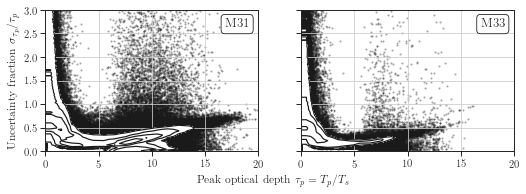

In [135]:
twocolumn_twopanel_figure(font_scale=1.2)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

ranges = [(0, 20), (0., 3.)]
# ranges = None

plot_density = False
bins = [20, 100]
alpha_dat = 0.4

hist2d(m31_peaktau[m31_peaktau_mask],
       (m31_peaktau_uncert / m31_peaktau)[m31_peaktau_mask],
       ax=axs[0],
       bins=bins,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

hist2d(m33_peaktau[m33_peaktau_mask],
       (m33_peaktau_uncert / m33_peaktau)[m33_peaktau_mask],
       ax=axs[1],
       bins=bins,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

# axs[0].scatter(m31_peaktau, m31_peaktau_uncert / m31_peaktau)
# axs[0].set_ylim([0, 2])

# axs[1].scatter(m33_peaktau, m33_peaktau_uncert / m33_peaktau)

axs[0].set_ylabel(r"Uncertainty fraction $\sigma_{\tau_p} / \tau_p$")
# axs[0].set_xlabel(r"$\tau_p = T_p / T_s$")

fig.text(0.5, 0.04, r"Peak optical depth $\tau_p = T_p / T_s$", ha='center')


# Make various text labels in the plots
# Labels
bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp = 0.9
yp = 0.9

axs[0].text(xp, yp, "M31",
            transform=axs[0].transAxes,
            horizontalalignment='center',
            verticalalignment='center',
            bbox=bbox_props, fontsize=13)
axs[1].text(xp, yp, "M33",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',
            bbox=bbox_props, fontsize=13)

axs[0].grid(True)
axs[1].grid(True)


fig.subplots_adjust(bottom=0.2, hspace=0.05)

# plt.tight_layout()

plot_name = 'm31_m33_peaktau_vs_uncertainty'

if save_figures:
    save_figure(fig, plot_name)


In [52]:
tab.colnames

['Tpeak',
 'Ts',
 'sigma',
 'thick_BIC',
 'mgauss_BIC',
 'mgauss_ncomps',
 'thick_BIC_taulim',
 'mgauss_BIC_taulim',
 'mgauss_ncomps_taulim',
 'npts_taulim',
 'darkint_total',
 'optthinint_total',
 'darkint_taulim',
 'optthinint_taulim']

Given the increased uncertainty at high tau, recompute the inferred dark HI mass for fits with smaller uncertainties:

In [136]:
taupeak_uncertfrac_limit = 1.0

m31taupeak_mask = (m31_peaktau_uncert / m31_peaktau) < taupeak_uncertfrac_limit
m33taupeak_mask = (m33_peaktau_uncert / m33_peaktau) < taupeak_uncertfrac_limit

m31_missing_intint_taulim = (m31_darknhi[m31taupeak_mask & np.isfinite(m31_darknhi_frac)] / 1000).sum()
m31_missing_intint_taulim = m31_missing_intint_taulim * u.K * u.km / u.s

m31_missing_hi_mass_taulim = m31_missing_intint_taulim * hi_mass_conversion * pix_area_m31

print(f"Dark HI Mass: {m31_missing_hi_mass_taulim}")
print(f"% of dark HI in M31 with tau / sigma_tau < 1: {100 * m31_missing_hi_mass_taulim / m31_total_optthin_mass}")
print(f"% of spectra {100 * (m31taupeak_mask & np.isfinite(m31_darknhi_frac)).sum() / np.isfinite(m31_darknhi).sum()}")


m33_missing_intint_taulim = (m33_darknhi[m33taupeak_mask & np.isfinite(m33_darknhi_frac)] / 1000).sum()
m33_missing_intint_taulim = m33_missing_intint_taulim * u.K * u.km / u.s

m33_missing_hi_mass_taulim = m33_missing_intint_taulim * hi_mass_conversion * pix_area_m33

print(f"Dark HI Mass: {m33_missing_hi_mass_taulim}")
print(f"% of dark HI in M33 with tau / sigma_tau < 1: {100 * m33_missing_hi_mass_taulim / m33_total_optthin_mass}")
print(f"% of spectra {100 * (m33taupeak_mask & np.isfinite(m33_darknhi_frac)).sum() / np.isfinite(m33_darknhi).sum()}")

Dark HI Mass: 1909303.9633742925 K km solMass / s
% of dark HI in M31 with tau / sigma_tau < 1: 0.11108557405366848 K km / s
% of spectra 25.341401088651
Dark HI Mass: 362443.15342547756 K km solMass / s
% of dark HI in M33 with tau / sigma_tau < 1: 0.03552332177528185 K km / s
% of spectra 20.666835765422064
